# Grad Times Image
this code has been adapted from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations)


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
from torchvision import models

#Read an image
from PIL import Image
import requests
from io import BytesIO
url ="https://github.com/SalvatoreRa/CNNscan/blob/main/img/manja-vitolic-gKXKBY-C-Dk-unsplash.jpg?raw=true"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#choose the model
pret_mod = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 142MB/s]


In [2]:
from matplotlib import cm
import copy
from torch.nn import ReLU
from torch.autograd import Variable

def process_img(img, model):
  norm_mean = [0.485, 0.456, 0.406]
  norm_std = [0.229, 0.224, 0.225]

  data_transform = transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(norm_mean, norm_std),
          ])
  im = data_transform(img)
  im = im.unsqueeze(0)
  output = model(im)
  _, pred_cls = output.max(dim=1, keepdim=True)
  im = Variable(im, requires_grad=True)
  return im, pred_cls

def format_np_output(np_arr):
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im):
  im = format_np_output(im)
  im = Image.fromarray(im)
  return im

def save_gradient_images(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    im =save_image(gradient)
    return im

def convert_to_grayscale(im_as_arr):
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


In [3]:
class IntegratedGradients():
    """
        Produces gradients generated with integrated gradients from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_images_on_linear_path(self, input_image, steps):
        step_list = np.arange(steps+1)/steps
        xbar_list = [input_image*step for step in step_list]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            integrated_grads = integrated_grads + single_integrated_grad/steps
        return integrated_grads[0]

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None

        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [6]:
def Grad_times_process(img, model):
  im, pred_cls = process_img(img, model)
  VBP = VanillaBackprop(model)
  vanilla_grads = VBP.generate_gradients(im, pred_cls)
  grad_times_image = vanilla_grads * im.detach().numpy()[0]
  grayscale_vanilla_grads = convert_to_grayscale(grad_times_image)
  grad_times_image = save_gradient_images(grad_times_image)
  grayscale_vanilla_grads = save_gradient_images(grayscale_vanilla_grads)

  GuideProg = GuidedBackprop(model)
  BackProg_grads = GuideProg.generate_gradients(im, pred_cls)
  BackProg_times_image = BackProg_grads * im.detach().numpy()[0]
  grayscale_BackProg_grads = convert_to_grayscale(BackProg_times_image)
  BackProg_times_image = save_gradient_images(BackProg_times_image)
  grayscale_BackProg_grads = save_gradient_images(grayscale_BackProg_grads)

  IG = IntegratedGradients(model)
  integrated_gradient = IG.generate_integrated_gradients(im, pred_cls, 100)
  integrated_grads_times = integrated_gradient * im.detach().numpy()[0]
  grayscale_int_grads_times = convert_to_grayscale(integrated_grads_times)
  integrated_grads_times = save_gradient_images(integrated_grads_times)
  grayscale_int_grads_times = save_gradient_images(grayscale_int_grads_times)
  return grad_times_image, grayscale_vanilla_grads, BackProg_times_image, grayscale_BackProg_grads, integrated_grads_times, grayscale_int_grads_times


def download_images(images, captions, cols = 3, rows = 1, size =10):
    n_img = len(images)
    n_plot = cols * rows
    figure, axis = plt.subplots(rows, cols)
    ax = axis.flatten()
    for i in range(n_img):
      ax[i].imshow(images[i])
      ax[i].axis('off')
      if captions is not None:
        ax[i].set_title(str(captions[i]), fontweight="bold", size=size)
    if n_img < n_plot:
      ax[-1].set_visible(False)
      ax[-2].set_visible(False)
    plt.tight_layout()

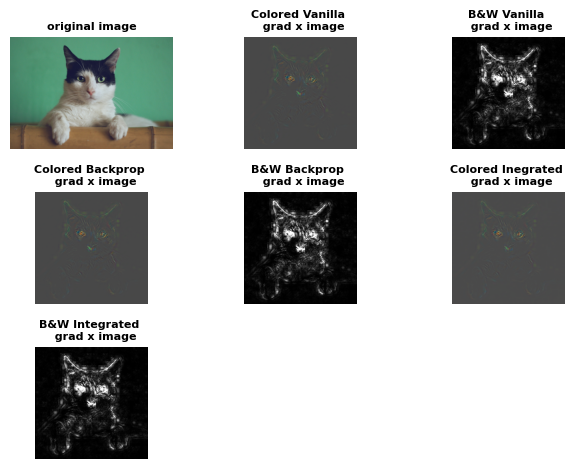

In [10]:
grad_times_image, grayscale_vanilla_grads, BackProg_times_image,grayscale_BackProg_grads, integrated_grads_times, grayscale_int_grads_times = Grad_times_process(img, pret_mod)

images = [img, grad_times_image, grayscale_vanilla_grads, BackProg_times_image,grayscale_BackProg_grads,
          integrated_grads_times, grayscale_int_grads_times ]
captions = ['original image', 'Colored Vanilla \n  grad x image',
            'B&W Vanilla \n  grad x image', 'Colored Backprop \n  grad x image', 'B&W Backprop \n  grad x image',
            'Colored Inegrated \n  grad x image', 'B&W Integrated \n  grad x image']
fig = download_images(images, captions, cols = 3, rows = 3, size = 8)